In [1]:
%load_ext autoreload
%autoreload 2
import gc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

from datetime import datetime
from glob import glob
from collections import defaultdict
from collections import Counter
from scipy.stats import sem

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from lib import Simulation
from lib import Consensus
from lib import Stat
from lib import Log
from lib import LogTorPS

from lib import ACTIVE_CIRCUITS_PER_SECOND
from lib import ACTIVE_CIRCUITS_PER_SECOND_STD

In [2]:
c = Consensus.generate(
    relay_info_path='../../tor-neverenough/experiments/active-links-0.3.5.18/relayinfo_staging_2021-11-01--2021-11-30.json',
    network_scale=1.0
)

sim = Simulation.from_consensus(c, N=ACTIVE_CIRCUITS_PER_SECOND).simulate()

sim.stat.create_table().T

Date                               2023-03-02 11:33:20.971615
Total Circuits                                   96876.000000
Total Links                                     185747.000000
Shared Links                                      7280.000000
Unshared Links                                  178467.000000
Shared Links Percent                                 3.919310
Total Circuit Parts                             193752.000000
Shared Circuit Parts                             15285.000000
Unshared Circuit Parts                          178467.000000
Shared Circuit Parts Percent                         7.888951
Total Guard-Middle Links                         93894.000000
Shared Guard-Middles Links                        2803.000000
Unshared Guard-Middles Links                     91091.000000
Shared Guard-Middles Percent                         2.985281
Total Middle-Exits Links                         91853.000000
Shared Middle-Exits Links                         4477.000000
Unshared Middle-Exits Links                      87376.000000
Shared Middle-Exits Links Percent                    4.874092
Complete Shared Circuits                             5.000000
Relays                                            5687.000000
Guards                                            2248.000000
Middles                                           4375.000000
Exits                                             1295.000000
Consensus Relays                                  6295.000000
Consensus Guards                                  2248.000000
Consensus Middles                                 4961.000000
Consensus Exits                                   1334.000000

In [3]:
N = ACTIVE_CIRCUITS_PER_SECOND

table = defaultdict(list)
for is_internal in [False, True]:
    for directed_links in [False, True]:
        for network_scale in np.array([1, 25] + list(range(10, 110, 10))):
            for _ in range(20):
                c = Consensus.generate(
                    relay_info_path='../../tor-neverenough/experiments/active-links-0.3.5.18/relayinfo_staging_2021-11-01--2021-11-30.json',
                    network_scale=network_scale/100
                )
                                
                sim = Simulation.from_consensus(
                    c, 
                    N=int(N * network_scale/100), 
                    is_internal=is_internal,
                    directed_links=directed_links,                    
                ).simulate()

                table['percent'].append(network_scale)
                table['N'].append(int(N * network_scale/100))
                table['shared'].append(float(sim.stat.create_table()['Shared Links Percent']))
                table['shared_guard_middle'].append(float(sim.stat.create_table()['Shared Guard-Middles Percent']))
                table['shared_middle_exit'].append(float(sim.stat.create_table()['Shared Middle-Exits Links Percent']))
                table['internal'].append(is_internal) 
                table['directed'].append(directed_links)                
            print('%d...' % network_scale, end='')

1...25...10...20...30...40...50...60...70...80...90...100...1...25...10...20...30...40...50...60...70...80...90...100...1...25...10...20...30...40...50...60...70...80...90...100...1...25...10...20...30...40...50...60...70...80...90...100...

In [4]:
table = pd.DataFrame(table)
table

percent      N     shared  shared_guard_middle  shared_middle_exit  \
0          1    968  56.205674            55.882353           56.589147   
1          1    968  57.586837            57.746479           57.414449   
2          1    968  56.405990            55.031447           57.950530   
3          1    968  58.721934            59.210526           58.181818   
4          1    968  56.173913            56.578947           55.719557   
..       ...    ...        ...                  ...                 ...   
955      100  96876   3.994033             2.984471            2.601592   
956      100  96876   3.991857             3.066392            2.429780   
957      100  96876   3.785440             2.830951            2.371048   
958      100  96876   3.912842             2.931659            2.507418   
959      100  96876   3.962502             3.065608            2.445741   

     internal  directed  
0       False     False  
1       False     False  
2       False     False  
3       False     False  
4       False     False  
..        ...       ...  
955      True      True  
956      True      True  
957      True      True  
958      True      True  
959      True      True  

[960 rows x 7 columns]

In [5]:
(
table[(table['percent']==100)&(table['internal']==False)&(table['directed']==False)]['shared'].mean(),
table[(table['percent']==100)&(table['internal']==True)&(table['directed']==False)]['shared'].mean(),
table[(table['percent']==100)&(table['internal']==False)&(table['directed']==True)]['shared'].mean(),
table[(table['percent']==100)&(table['internal']==True)&(table['directed']==True)]['shared'].mean()
)

(4.342634061369782, 6.396421072526417, 3.9676908180562243, 3.9493339043012177)

In [6]:
(
table[(table['percent']==100)&(table['internal']==False)&(table['directed']==False)]['shared_guard_middle'].mean(),
table[(table['percent']==100)&(table['internal']==True)&(table['directed']==False)]['shared_guard_middle'].mean(),
table[(table['percent']==100)&(table['internal']==False)&(table['directed']==True)]['shared_guard_middle'].mean(),
table[(table['percent']==100)&(table['internal']==True)&(table['directed']==True)]['shared_guard_middle'].mean()
)

(3.6926871983685685, 3.7110003493824886, 2.978568528749874, 3.0159341002417546)

In [7]:
(
table[(table['percent']==100)&(table['internal']==False)&(table['directed']==False)]['shared_middle_exit'].mean(),
table[(table['percent']==100)&(table['internal']==True)&(table['directed']==False)]['shared_middle_exit'].mean(),
table[(table['percent']==100)&(table['internal']==False)&(table['directed']==True)]['shared_middle_exit'].mean(),
table[(table['percent']==100)&(table['internal']==True)&(table['directed']==True)]['shared_middle_exit'].mean()
)

(5.002948920661728, 4.444193457872548, 4.979726817470398, 2.473775276371184)

In [8]:
table.groupby(['internal', 'directed']).mean()

percent             N     shared  shared_guard_middle  \
internal directed                                                          
False    False        48.0  46500.083333  13.186747            12.226938   
         True         48.0  46500.083333  12.204911            10.304076   
True     False        48.0  46500.083333  16.645389            12.224709   
         True         48.0  46500.083333  12.002186            10.368344   

                   shared_middle_exit  
internal directed                      
False    False              14.188620  
         True               14.333007  
True     False              12.349384  
         True                8.414937

```
Internal Directed Shared
False    False    12.234944 blue
False    True     11.299479 orange
True     False    15.460821 green
True     True     11.045976 red
```

In [9]:
table[table['percent']==100].groupby(['internal', 'directed']).mean()

percent        N    shared  shared_guard_middle  \
internal directed                                                    
False    False       100.0  96876.0  4.342634             3.692687   
         True        100.0  96876.0  3.967691             2.978569   
True     False       100.0  96876.0  6.396421             3.711000   
         True        100.0  96876.0  3.949334             3.015934   

                   shared_middle_exit  
internal directed                      
False    False               5.002949  
         True                4.979727  
True     False               4.444193  
         True                2.473775

In [10]:
table.groupby(['percent', 'internal', 'directed']).mean()

N     shared  shared_guard_middle  \
percent internal directed                                            
1       False    False       968.0  57.074213            56.405016   
                 True        968.0  53.950612            49.933778   
        True     False       968.0  62.191391            56.049406   
                 True        968.0  53.110067            50.756029   
10      False    False      9687.0  23.351287            21.915601   
                 True       9687.0  21.334320            17.993867   
        True     False      9687.0  29.608911            22.080607   
                 True       9687.0  21.087250            17.884736   
20      False    False     19375.0  15.304530            14.006401   
                 True      19375.0  13.932837            11.386780   
        True     False     19375.0  20.523775            14.052013   
                 True      19375.0  13.941874            11.359152   
25      False    False     24219.0  13.165932            11.881732   
                 True      24219.0  12.044701             9.679486   
        True     False     24219.0  17.803664            11.919518   
                 True      24219.0  11.954891             9.720545   
30      False    False     29062.0  10.611200             9.438260   
                 True      29062.0   9.592445             7.575381   
        True     False     29062.0  14.561914             9.452485   
                 True      29062.0   9.409272             7.535507   
40      False    False     38750.0   8.148590             7.028209   
                 True      38750.0   7.465648             5.774820   
        True     False     38750.0  11.311897             7.051220   
                 True      38750.0   7.221199             5.761325   
50      False    False     48438.0   7.840352             6.856591   
                 True      48438.0   7.158115             5.527677   
        True     False     48438.0  11.158053             6.873330   
                 True      48438.0   7.146827             5.580468   
60      False    False     58125.0   5.565455             4.635682   
                 True      58125.0   5.208855             3.937973   
        True     False     58125.0   7.641592             4.652139   
                 True      58125.0   4.826183             3.948225   
70      False    False     67813.0   4.490556             3.779719   
                 True      67813.0   4.175555             3.145081   
        True     False     67813.0   6.330559             3.780327   
                 True      67813.0   3.911788             3.107346   
80      False    False     77500.0   4.208631             3.562078   
                 True      77500.0   3.821165             2.862313   
        True     False     77500.0   6.094170             3.524098   
                 True      77500.0   3.702946             2.866790   
90      False    False     87188.0   4.137579             3.521280   
                 True      87188.0   3.806992             2.853185   
        True     False     87188.0   6.122320             3.550361   
                 True      87188.0   3.764596             2.884070   
100     False    False     96876.0   4.342634             3.692687   
                 True      96876.0   3.967691             2.978569   
        True     False     96876.0   6.396421             3.711000   
                 True      96876.0   3.949334             3.015934   

                           shared_middle_exit  
percent internal directed                      
1       False    False              57.846919  
                 True               59.471942  
        True     False              50.870645  
                 True               41.793105  
10      False    False              24.894521  
                 True               25.123513  
        True     False              21.540697  
                 True               14.538470  
20      False    False              16.667828  
    

In [11]:
directed = table[table['directed']]
internal_directed = directed[~directed['internal']]
internal_directed[internal_directed['percent']==25]['shared'].mean()

12.044701253318243

In [12]:
table_min_max = table[['percent', 'shared']].groupby('percent').agg(['min', 'max'])

In [13]:
table_min_max[('shared', 'min')]

percent
1      50.874636
10     20.535898
20     13.394161
25     11.613056
30      8.987735
40      6.912211
50      6.868092
60      4.556372
70      3.717022
80      3.529522
90      3.487300
100     3.744978
Name: (shared, min), dtype: float64

In [14]:
shadow_simulation = defaultdict(list)
shadow_simulation['percent'].extend([25]*5)
shadow_simulation['shared'].extend([0.123649,0.124677,0.126367,0.127302,0.123650])
shadow_simulation = pd.DataFrame(shadow_simulation)
shadow_simulation['shared'] *= 100
shadow_simulation

percent   shared
0       25  12.3649
1       25  12.4677
2       25  12.6367
3       25  12.7302
4       25  12.3650

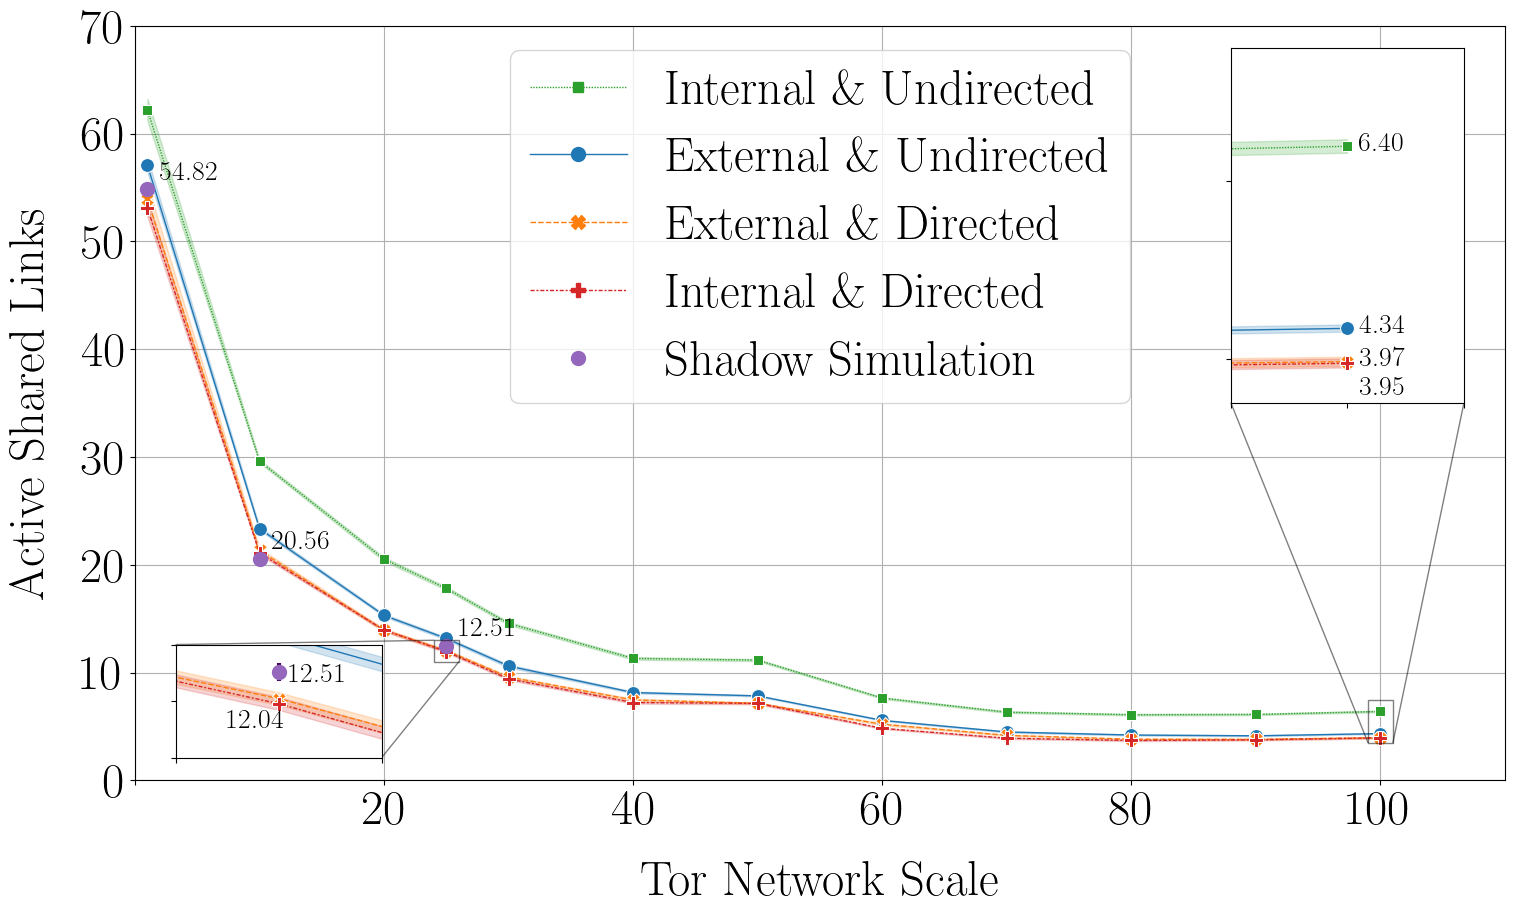

In [16]:
def annotate_value(xy, label=None, offset=(1, 1), color=None, ax=None):
    cm = plt.get_cmap('tab10')
    if ax is None:
        ax = plt.gca()
    if color is not None: 
        ax.plot(*xy, 'o', label=label, color=cm(color))
    ax.annotate('%.2f %%' % xy[1], xy=xy, xytext=(xy[0] + offset[0], xy[1] + offset[1]), fontsize=20)
    
def format_percent(x, pos=None, digits=0, xmax=100):
    x = x / xmax * 100
    format_string = '%%.%df %%%%' % digits
    return format_string % x

import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

plt.rc('font', family='cmr10')
plt.rc('font', size=35)
plt.rc('axes', axisbelow=True)
plt.rc('axes.formatter', use_mathtext=True)
plt.rc('lines', linewidth=1.0, markersize=10.0)

plt.figure(figsize=(16, 10))
sns.lineplot(
    data=table, 
    x='percent', 
    y='shared', 
    hue=table[['internal', 'directed']].apply(tuple, axis=1), 
    style=table[['internal', 'directed']].apply(tuple, axis=1),
    marker='o', 
    markers=True,
    ax=plt.gca(), 
    errorbar=('ci', 99),
)
plt.gca().legend(['1', '2', '3', '4'])

plt.xlabel('Tor Network Scale', labelpad=20)
plt.ylabel('Active Shared Links', labelpad=20)
plt.gca().xaxis.set_major_formatter(format_percent)
plt.gca().yaxis.set_major_formatter(format_percent)
plt.gca().grid(True)
plt.xlim(0, 110)
plt.ylim(0, 70)

annotate_value((25, shadow_simulation['shared'].mean()), label='LEGEND', color=4)
# ax.plot(25, shadow_simulation['shared'].mean(), 'o', color=plt.get_cmap()(4))
annotate_value((10, 20.56), color=4)
annotate_value((1, 54.82), color=4)

handles, labels = plt.gca().get_legend_handles_labels()

labels[0] = 'External \& Undirected'
labels[1] = 'External \& Directed'
labels[2] = 'Internal \& Undirected'
labels[3] = 'Internal \& Directed'
labels[4] = 'Shadow Simulation'

legend = list(zip(handles, labels))
legend = [
    legend[2], legend[0], legend[1], legend[3], 
    legend[4]
]

handles, labels = zip(*legend)
plt.gca().legend(handles, labels)

###
ax = plt.gca()
axins = ax.inset_axes([0.8, 0.5, 0.17, 0.47])
sns.lineplot(
    data=table, 
    x='percent', 
    y='shared', 
    marker='o', 
    markers=True,
    legend=None, 
    hue=table[['internal', 'directed']].apply(tuple, axis=1), 
    style=table[['internal', 'directed']].apply(tuple, axis=1),
    ax=axins, 
    errorbar=('ci', 99),    
)
axins.set_xlabel(None)
axins.set_ylabel(None)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.grid(False)

axins.set_xlim(99, 101)
axins.set_ylim(3.5, 7.5)

ax.indicate_inset_zoom(axins, edgecolor="black")

st = table[table['percent']==100]
annotate_value((100, st[(st['internal'] == True) & (st['directed'] == False)].mean()['shared']), offset=(0.1, -0.04), ax=axins)
annotate_value((100, st[(st['internal'] == False) & (st['directed'] == False)].mean()['shared']), offset=(0.1, -0.04), ax=axins)
annotate_value((100, st[(st['internal'] == False) & (st['directed'] == True)].mean()['shared']), offset=(0.1, -0.04), ax=axins)
annotate_value((100, st[(st['internal'] == True) & (st['directed'] == True)].mean()['shared']), offset=(0.1, -0.35), ax=axins)

###
axins = ax.inset_axes([0.03, 0.03, 0.15, 0.15])
sns.lineplot(
    data=table, 
    x='percent', 
    y='shared', 
    marker='o', 
    markers=True,
    legend=None, 
    hue=table[['internal', 'directed']].apply(tuple, axis=1), 
    style=table[['internal', 'directed']].apply(tuple, axis=1),
    ax=axins, 
    errorbar=('ci', 99),
)

axins.errorbar(
    x=[25+0.003], 
    y=[shadow_simulation['shared'].mean()],
    yerr=shadow_simulation['shared'].std(),
    data=shadow_simulation,    
    color=plt.get_cmap()(4),
    elinewidth=3.0,
)

annotate_value((25, shadow_simulation['shared'].mean()), offset=(0.1,-0.15), color=4, ax=axins)
st = table[table['percent']==25]
xy = (25, st[(st['internal'] == False) & (st['directed'] == True)].mean()['shared'])
offset = (-0.5,-0.5)
axins.annotate('%.2f %%' % xy[1], xy=xy, xytext=(xy[0] + offset[0], xy[1] + offset[1]), fontsize=20)

axins.set_xlabel(None)
axins.set_ylabel(None)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.grid(False)

axins.set_xlim(24, 26)
axins.set_ylim(11, 13)

ax.indicate_inset_zoom(axins, edgecolor="black")
###

plt.gca().get_xticklabels()[0].set_color('white')
plt.tight_layout()
plt.savefig('paper-shared-links-vs-network-size.pdf')
plt.show()